# Graph Analysis


In this notebook I perform analysis of Twitter graph data of 1.6m Tweets that were collected over the course of a day. First, I look at the global graph statistics, followed by analysis of Tweeter ego-centric networks. Finally I implement a function to simulate random walks in the graph, and use this alongside the Word2Vec algorithm and the t-SNE algorithm to embed Tweeters onto a 2-dimensional space. These are visualised on a graph to identify clusters.


## Description of data collection and data format

I collected tweets that contained the words 'covid' and 'coronavirus' over the course of 24 hours using using the `kafka_twitter_producer.py` and `twitter_collector.py` scripts, as documented in the `Spark Streaming` tutorial. Here I provide an explanation of the arguments used when running both, and their implications

Arguments passed with the `kafka_twitter_producer.py` script were as such:

    --topic covid
    --filter coronavirus covid

1. `topic` specified the name of the topic that the Kafka consumer connections to.

2. `filter` specifies that the incoming stream of tweets will be filtered to contain only those that contain words 'coronavirus' and 'covid'.

Arguments passed with the `tweet_collector.py` script were as such:

    --interval_length 20
    --num_partitions 2
    --path gs://----bucket/data
    --topic covid
    --graph False

1. `interval_length` specifies the time interval chosen for streaming (the length of time to collect each batch of tweets). I chose it to be 20 seconds. 

2. `num_partitions` sets the number of partitions that the RDDs in the DStream are coalesced to. I explored possible different values for this:
    - The default in Spark is 20, and at first I found that the saveAsTextFiles function for saving outputs was significantly increasing processing time of each batch of tweets: for 20 seconds of tweets it would take 1 minute and thus a large queue of unprocessed tweets was building up. This is because, when each RDD was saved as a textfile, each of the 20 partitions were saved as an individual files, and as the streaming is ran on a cluster with a single node, it has to save each file in turn.
    - I experimented with coalescing to different numbers: when coalesced to 1 the processing dimished and tweets were being processed in real time, however I found that the limits on the rate of requests of tweets using Twitter API meant that I had periods of missing incoming tweets. 
    - Finally, I chose the number of partitions to be 2, as the processing of 2 partitions cause no significant delays on the incoming DStream, while ensuring a constant stream without any interruptions due to the Twitter API limit.

3. `path` was set to be a folder in a GCP bucket.

4. `topic` was set to 'covid', to match the topic specified by the Kafka producer.

5. `graph` argument passed as `False` so that the data was saved as "tweet rows" that can be imported as an RDD and then converted to a Spark DataFrame where each row is a tweet. It would also have been possible to pass `True` and to specify `graph_type` to get graph edges and vertices. In this notebook we instead transform the tweet rows into graph form after they have been imported, by using the `get_tweet_rows` function stored in the `tweet_collector.py` file.

Each item in the saved textfiles is a tweet row that contains the following information:
    - Tweeter username and ID
    - Time of tweet
    - Language
    - Text of tweet
    - Other users mentioned in Tweet, via a 'reply', 'mention' or 'retweet'
    - Hashtags
    - URLs
    
## Set up of cluster

A cluster is set up to enable the creation of GraphFrames:

``` 
gcloud beta dataproc clusters create ----cluster \
--optional-components=ANACONDA,JUPYTER \
--image-version=1.3 \
--enable-component-gateway \
--properties=^#^spark:spark.jars.packages=graphframes:graphframes:0.5.0-spark2.1-s_2.11,com.databricks:spark-xml_2.11:0.4.1 \
--bucket ----bucket \
--project st446-267513
```

In [ ]:
#Import get_tweet_rows from tweet_collector.py
from tweet_collector import get_tweet_rows

#Import other needed packages
import pandas as pd
import numpy as np
from time import time 
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import desc
from graphframes import GraphFrame
from pyspark.sql.functions import explode
from pyspark.sql.functions import lower, col

#Set directory
sc.setCheckpointDir('gs://----bucket/temp')

### Download Collected Twitter Data

The collected data is stored on in a bucket in Google Cloud Storage.

Now a list of all the data textfiles is created. A SparkContext (sc) is used to create an RDD on the Dataproc cluster from all of these textfiles. I then checked the number of partitions in the RDD.

In [1]:
from google.cloud import storage
import re
from time import time

client = storage.Client()
bucket = client.bucket('----bucket')
blobs = list(bucket.list_blobs(prefix='data/'))

files = ["gs://----bucket/" + str(blob.name) for blob in blobs if 'part-' in str(blob.name)]
data_from_file = sc.textFile(','.join(files))

print("Number of Partitions in the RDD: {}".format(data_from_file.getNumPartitions()))

Number of Partitions in the RDD: 6721


The number of partitions is so large, because one partition is created for each textfile uploaded. Having such a large number of partitions, each of which contains only small data, in the RDD is likely to cause inefficiencies in computations. We consider how we would like repartition our data:

    - Too large a number of partitions will cause a large amount of overhead for managing small tasks, thus increasing the running time of computations.
    
    - On the other hand, too few partitions would mean that not all the cores in the cluster will be utilised, and there will not be the advantages of parallel computing.
    
I chose to coalesce the RDD to 12 partitions as this is 3 partitions for each node in the cluster (there are 4 in total, including 1 master node and 3 workers)

In [ ]:
rdd = data_from_file.coalesce(12).cache()
tweet_rdd = rdd.map(lambda row: [eval(item) if i > 2 else item for i, item in enumerate(row.split("\t\t"))]).cache()

Turn into a PySpark dataframe.

In [8]:
columns = ['user_id', 'user', 'location', 'timestamp', 'tweet_id', 'retweet', 'text', 'language', 'user_mention_ids', 'user_mentions', 'hashtags', 'urls']
df = tweet_rdd.toDF(columns).distinct().cache()

Create graph

In [ ]:
vertices = rdd.map(lambda x: (eval(x), identify_tweet(eval(x)))).filter(lambda x: x[1] is True).flatMap(lambda x: get_tweet_row(x[0], "tweeter_vertices")).cache()
edges = rdd.map(lambda x: (eval(x), identify_tweet(eval(x)))).filter(lambda x: x[1] is True).flatMap(lambda x: get_tweet_row(x[0], "tweeter_edges")).cache()

verticesColumns = ['id']
edgesColumns = ['src', 'dst', 'timestamp', 'tweet_id', 'retweet', 'text', 'language', 'hashtags', 'urls']

verticesDF = vertices.map(lambda x: Row(x)).toDF(verticesColumns).distinct().cache()
allEdgesDF = edges.toDF(edgesColumns).distinct().cache()
edgesDF = allEdgesDF.select("src", "dst").where(col("src")!=col("dst")).groupby("src", "dst").count().withColumnRenamed("count","weight")

graph = GraphFrame(verticesDF, edgesDF).cache()

### Graph Analysis

We perform analysis on the network graph, by using RDD, PySpark DataFrame and GraphFrame operations.

First we calculate summary statistics of the graph and tweet characteristics.

- Total numbers of: tweets, users
- Distributions of tweets: language, retweet
- Connected components
- Triangles (triplets of users who share edges)

Then we look at individual users and their ego-centric networks: 

- in-degree, out-degree
- one hop with triangles
- two-hop
- clustering coefficients
- pagerank

In [ ]:
n_tweets = df.count()
n_users = graph.vertices.count()
n_edges = graph.edges.count()
n_hashtags = df.select(explode(df.hashtags)).distinct().count()

print("    Number of Tweets: {}".format(n_tweets))
print("     Number of Users: {}".format(n_users))
print("Number of User Edges: {}".format(n_edges))
print("  Number of Hashtags: {}".format(n_hashtags))

    Number of Tweets: 1612045
     Number of Users: 1127108
Number of User Edges: 1557228
  Number of Hashtags: 103469


We are anticipating that the network graph composed from such a collection of tweets will not enable us to create detailed ego-centric networks of individual users (since there is 1.5 tweets per user). Only with sufficient tweeting activities we can discover the social network, e.g. Twitter followers, and communities.

Using the GraphFrame built in operations, we now calculate the total number of connected components in the graph and the total number of triangles.

In [ ]:
graphtc = graph.triangleCount().cache()
graphCC = graph.connectedComponents().cache()

In [1]:
ncc = graphCC.select("component").distinct().count()
tc = graphtc.agg({"count":"sum"}).collect()[0][0]
n_triangles = graph.vertices.count()
n_edges = graph.edges.count()
n_hashtags = df.select(explode(df.hashtags)).distinct().count()
time1 = time()

print("Number of Connected Components: {}".format(ncc))
print("           Number of Triangles: {}".format(n_triangles))


Number of Connected Components: 190519
           Number of Triangles: 1127108



In [2]:
graphCC.groupBy("component").count().sort(desc("count")).show(5)


+-----------+-------+
|  component|  count|
+-----------+-------+
|          0| 846387|
|       6448|    362|
|17179871133|    169|
|       3919|    144|
|17179875962|    100|
+-----------+-------+
only showing top 5 rows



75% of users are in a single connected component and all other components are no more that 362 users. 

Graphs presenting Tweet characteristics:
- distribution of languages
- distribution of tweets vs retweets

In [81]:
def plot_bar(count_list, type, ax, extra = None):
    if extra is None:
        x = [str(item[0]) for item in count_list]
    elif extra == 'language':
        x = [lang_dict[str(item[0])] for item in count_list]
    y = [item[1] for item in count_list]
    x_pos = [i for i, _ in enumerate(x)]
    
    ax.bar(x, y)
    ax.set_xticks(sorted(range(len(y)), key=lambda k: y[k]), x)
    ax.set_xlabel(type)
    ax.set_ylabel("Number of Tweets")
    ax.set_title("Distribution of " + type + "s")
    
def plot_hist(count_list, ob, ax, lower=0, upper=1):
    
    y = [count_list[i][1] for i in range(int(round((1-upper)*len(count_list))), int(round((1-lower)*len(count_list))))]
    ax.hist(y, bins= 20)
    ax.set_xlabel(ob)
    ax.set_title("Histogram of " + ob + "s")

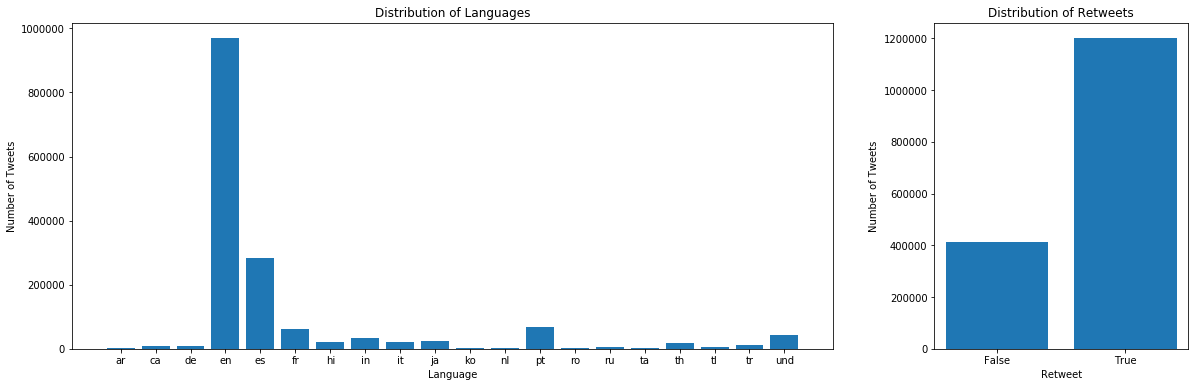

In [56]:
#distribution of languages and RTs
languages = df.select('language').groupBy("language").count().sort(desc("count")).rdd.map(lambda row: (row[0], row[1])).take(20)
retweets = df.select('retweet').groupBy("retweet").count().sort(desc("count")).rdd.map(lambda row: (str(row[0]), row[1])).collect()

fig, ax = plt.subplots(1, 2, figsize= (20, 6), gridspec_kw={'width_ratios': [3, 1]})
plot_bar(count_list=languages, type="Language", ax=ax[0])#, extra = 'language')
plot_bar(count_list=retweets, type="Retweet", ax=ax[1])

The above bar chart on the left shows the distribution of tweets across languages. One can see that English is by far the most common language, followed by Spanish, Portuguese and French.

The above bar chart to the right shows there are 3 times more retweets than retweets (1.2m retweets for 400,000 tweets). This shows that users are mostly propagating others' tweets rather than creating their own content.

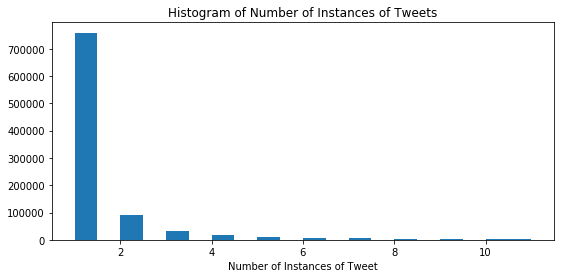

In [40]:
number_of_RTs = df.select('tweet_id').groupBy("tweet_id").count().sort(desc("count")).rdd.map(lambda row: (str(row[0]), row[1])).collect()
plot_hist(number_of_RTs, fig_size=(9, 4), object="Number of Instances of Tweet", lower=0.05, upper=0.975)

From the bar chart above we note that the data contains 750,000 tweets with unique tweet IDs. That means tweeters posted a new tweet or we are capturing retweets from previously unobserved tweets that were originally posted before we started data collection. 

Distributions:
- in-degree
- out-degree
- number of triangles
- two-hop reaches
- clustering coefficient
- pagerank

In [ ]:
inDegrees = graph.inDegrees.sort(desc("inDegree")).rdd.map(lambda row: (str(row[0]), row[1])).collect()
outDegrees = graph.outDegrees.sort(desc("outDegree")).rdd.map(lambda row: (str(row[0]), row[1])).collect()

Distribution of Users' In-Degrees and Out-Degrees

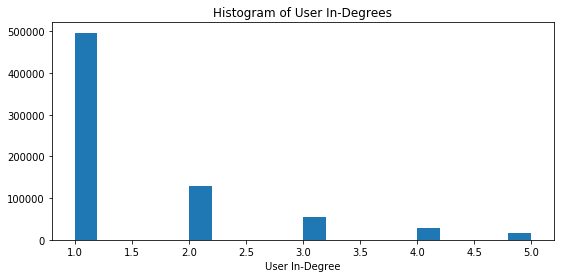

In [203]:
plot_hist(inDegrees, fig_size=(9, 4), ob="User In-Degree", lower=0.05, upper=0.95)
plot_hist(outDegrees, fig_size=(9, 4), ob="User Out-Degree", lower=0.05, upper=0.95)

We consider a directional graph where A -> B means that A was retweeted, replied to or mentioned by B. A user's in-degree represents the number of times they have retweeted, replied to or mentioned another use.

The graph above shows that 500,000 users have an in-degree of 1, meaning there is not much activity of users towards other users in the timeframe of data collection. This number reduces as in-degrees increase with a long tail.

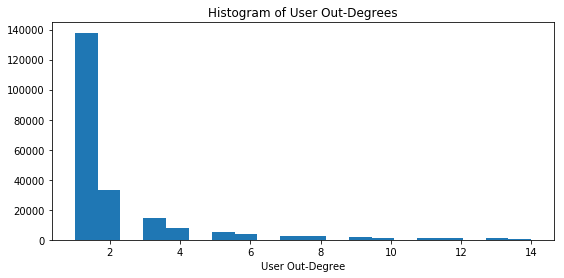

In [204]:
plot_hist(outDegrees, fig_size=(9, 4), ob="User Out-Degree", lower=0.05, upper=0.95)

The out-degree of a user represents the number of times another user has retweeted, mentioned or replied to them. The number of users with 1 out-degree is 140,000, a 1/3 of the number of users with 1 in-degree. This implies that users are more likely to have higher out-degrees then in-degrees. 

Now we observe the two-hop reach of users. This is calculated by using a search motif to find all possible two hop paths, i.e. paths of length two from a user, and then filtering these two hop path

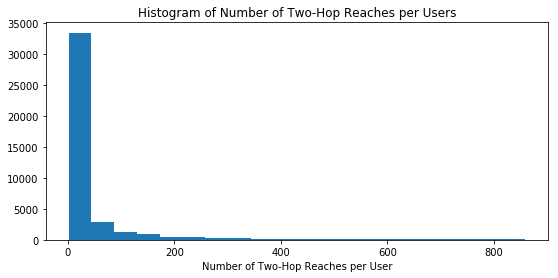

In [175]:
two_hop = graph.find("(a)-[]->(b);(b)-[]->(c)").cache()
two_hop_reach = two_hop.where("a != c").groupBy("a").count().sort(desc("count")).cache()
twohop = two_hop_reach.rdd.map(lambda row: (str(row[0]), row[1])).collect()

plot_hist(twohop, fig_size=(9, 4), ob="Number of Two-Hop Reaches per User", lower=0.05, upper=0.975)

Above is the histogram showing the number of two-hop reaches per user. It shows that lower reaches are most common for users and this tapers of as the reach size increases.

Then we calculate clustering coefficients for users. This is:

    number of degrees / k * (k - 2)
    
It measures how similar user's neighbourhood are to a clique. We calculate this by:

    - joining the DataFrame of number of degrees per user on number of triangles per user, by user ID.
    - creating a new column 'coefficient', whose values are a function of the number of triangles and the number of degrees for that user

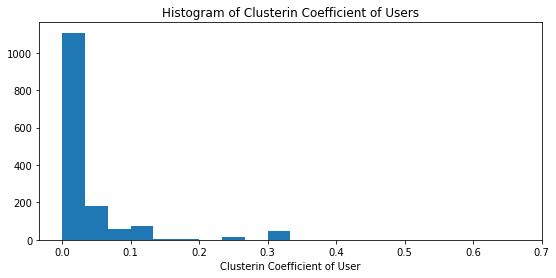

In [192]:
tcs = graphtc.rdd.map(lambda row: (str(row[0]), row[1])).collect()
clustering_coefs = graphtc.join(graph.degrees, on = 'id') \
                                .withColumn('coefficient', col('count')/(col('degree')*(col('degree')-2))).cache()
coefs = clustering_coefs.select("id", "coefficient").na.drop().rdd.map(lambda row: Row(str(row[0]), row[1])).collectAsMap()

plot_hist(coefs, fig_size=(9, 4), ob="Clusterin Coefficient of User", lower=0, upper=1)

As one can see from the histogram of clustering coefficients per user, most users have a low clustering coefficient. This is aligned with our observations about the graph so far: that it is sparse.

We can also run the pagerank algorithm to rank the import of Twitter users in the network:

In [300]:
pr = graph.pageRank(resetProbability=0.15, maxIter=10).cache()
pr.vertices.show()

+---------------+------------------+
|             id|          pagerank|
+---------------+------------------+
|          2KyDO| 0.821617878468969|
|   2lesungpipit|0.8612354074849639|
|        CL97071|0.8086007645839142|
|Front_ChoKo_Sky|0.8182765388819846|
|  Marie64897898|0.8070310246047059|
|      Maryljacb|0.8070310246047059|
|  Moonlight_the|0.9410641591756146|
|    NutleyGirl5|  0.86725215220818|
|  Pattyz_PcyBbh|0.8072727357995312|
|ReporteGaritero|0.8070310246047059|
|         Ro1951|0.8070770108198239|
| Situsinversus_|0.8070310246047059|
|      SulPanaro|0.8070310246047059|
|      SynoTrixx|0.8070310246047059|
|       _razieel|1.4930073955187058|
|    aninhafxr__| 0.808365608983916|
|     de_sputnik|0.8070310246047059|
|       francman|1.4930073955187058|
|minnasiawase711|1.4930073955187058|
|    pattykvilla|0.8202042616315774|
+---------------+------------------+
only showing top 20 rows



### Graph Embedding and Visualisation

Here we define two functions:

1) Random walk
2) Graph embedding

#### Random Walk

This allows use to generate n random walks per user of a specified maximum length. The function involves an iterative series of join, map and reduce functions on an RDD of users.

Specifically, starting with an RDD, where each item is a vertex ID (in our case these are usernames), the following operations are performed:

1. Generate the starting points for n random walks per vertex, with a unique identifier for the random walk, used in the reduce parts.

2. Then random walks are started. The following set of operations is run for the number of times equal to the maximum length of walk.

 - Do a left outer join of the edge RDD onto the random walk RDD, by the most recent vertex in the random walk to get all neighbours and thus next possible steps in the walk.
 
 - Do a reduce to create a collect all the neighbours in a list per unique vertex and random walk, and select one randomly as the next step.
 
 - This neighbour is added to the random walk sequence.
 
 - If the most recent vertex in the random walks has no neighbours that it can move to, that random walk has finished.
 
#### Node2Vec
This is an algorithm used to embed graph vertices onto a vector space. This is made of two parts:

1) random walks in the graph and 
2) Word2Vec.

The Word2Vec algorithm takes the user random walks as inputs and finds vector representations of users that maximise the  likelihood  of  preserving  networkneighborhoods of nodes. 


#### Visualisation 

The vectors output by the Node2Vec algorithm can then be embedding onto a 2-dimensional space for visualisation. This final embedding is done by the t-SNE algorithm. 

Specifically the t-SNE algorithm finds the 2-dimensional embedding by minimising the KL divergence between joint probabilities of data points in the 2-dimensional embedding and of data points in the output vectors of the Word2Vec algorithm.

#### Implementation

4 functions are documented below:

- `generate_random_walks`: generates specified number of walks per user in the input graph, with maximum walk length.

- `embed_walks`: input random walks into the Word2Vec function and embeds the output onto a 2-dimensional space that csn be plotted in graphs.

- `plot_grouped_embedding`: plots the embedded graph users, colouring them by a discrete variable in the data.

- `plot_gradient_embedding`: plots the embedded graph users, colouring them by a continuous variable in the data.

In [5]:
def generate_random_walks(vertices, edges, num_walks=5, len_walks=20):
    """
    PySpark function to simulate num_walks random walks per vertex in a graph, with maximum length len_walks.
    In total num_walks * vertices.count() random walks will be created.
    Parameters
    ----------
    vertices : vertices RDD of graph
    edges : edges RDD of graph
    num_walks : number
    len_walks :

    Returns
    -------
    An RDD of random walks
    """
    import random
    walkers = vertices.flatMap(lambda id: [(id[0], (num, [id[0]])) for num in range(num_walks)])
    for _ in range(len_walks - 1):
        walkers = walkers.leftOuterJoin(edges) \
            .map(lambda row: ((row[0], row[1][0][0]), (row[1][0][1], [row[1][1]]))) \
            .reduceByKey(lambda a, b: (a[0], a[1] + b[1])) \
            .map(lambda row: (row[0], row[1][0] + [random.choice(row[1][1])])) \
            .map(lambda row: (row[0], [item for item in row[1] if item is not None])) \
            .map(lambda row: (row[1][-1], (row[0][1], row[1]))) \
            .coalesce(200)
    return walkers.map(lambda x: x[1][1])


def embed_walks(walks, vector_size=20, dimension=2, seed=42):
    """
    Feeds a set of random walks in a graph into the Word2Vec algorithm in the PySpark MMLib.
    This produces multi-dimensional vector representations of the vertices, each with vector_size dimensions.
    The t-SNE algorithm is then used to embed the vertex vectors onto a new dimensional space, default 2-dim.
    Parameters
    ----------
    walks : RDD of random walks in the graph
    vector_size : length of vectors to be output by the Word2Vec algorithm
    dimension : size of the t-SNE embeddings of the vectors
    seed : set the seed for the Word2Vec algorithm

    Returns
    -------
    vectors: list of (user, Word2Vec vector) pairs
    users: list of users
    embeddings: the t-SNE embedding of the Word2Vec vectors
    model: Word2Vec model
    tsne_2d: t-SNE model
    """
    from pyspark.mllib.feature import Word2Vec
    from sklearn.manifold import TSNE

    model = Word2Vec().setVectorSize(20).setSeed(seed).fit(walks)
    vectors = model.getVectors()
    embeddings = [vector for _, vector in vectors.items()]
    users = vectors.keys()
    tsne_2d = TSNE(n_components=2, verbose=1, random_state=0, init='pca')
    embeddings_2d = tsne_2d.fit_transform(embeddings)
    
    return vectors, users, embeddings_2d, model, tsne_2d


def plot_grouped_embedding(data, group_by, title, size=7, aspect=1.5, alpha=0.5):
    """
    Plot the 2-dimensional data and colour the scatter plot values by a categorical characteristic.
    Parameters
    ----------
    data : 2-dimensional data to plot
    group_by : discrete factor to colour the scatter points by
    title : title of graph
    size : size of graph
    aspect : aspect of the graph
    alpha : opaqueness of the scatter points

    Returns
    -------
    Plot of the graph data on a 2-dimensional graph.
    """

    import seaborn as sns
    import matplotlib.pyplot as plt

    data_to_plot = data.groupby(group_by)
    _hue_order = data[group_by].unique()
    sns.set(style='ticks')
    fg = sns.FacetGrid(data=data_to_plot, hue=group_by, hue_order=_hue_order, aspect=aspect, size=size)
    fg.map(plt.scatter, 'x', 'y', alpha=alpha).add_legend()
    plt.title(title)

def plot_gradient_embedding(data, colorby, title, figsize=(12, 10), alpha=0.7):
    """
    Plot the 2-dimensional data and colour the scatter plot values by a continuous characteristic.
    Parameters
    ----------
    data : 2-dimensional data to plot
    colorby : continuous factor to colour the scatter points by
    title : title of graph
    figsize : size of the plotted figure
    alpha : opaqueness of the scatter points

    Returns
    -------
    Plot of the graph data on a 2-dimensional graph.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    cmap = sns.cubehelix_palette(as_cmap=True)
    fig, ax = plt.subplots(figsize=figsize)
    points = ax.scatter(data_to_plot["x"], data_to_plot["y"], c=data_to_plot[colorby], s=50, cmap=cmap, alpha=alpha)
    fig.colorbar(points)
    plt.title(title)

Prepare edges and vertices for generating random walks

In [ ]:
r_walk_edges = allEdgesDF.select('src', 'dst').rdd.map(lambda row: (row[0], row[1])).distinct().cache()
r_walk_edges = edges.filter(lambda row: row[0] != row[1])
ids = verticesDF.rdd

Generate 5 random walks starting at each user of maximum length 20.

In [ ]:
r_walks = generate_random_walks(ids, r_walk_edges, num_walks=5, len_walks = 20).cache()
walks = r_walks.filter(lambda row: len(row) > 1).cache()
vectors, users, embeddings_2d = embed_walks(walks, vector_size = 100)

In [ ]:
#create user-characteristic mappings to be used in the plots 
lang_map = verticesDF.join(allEdgesDF.withColumnRenamed('src', 'id'), on='id', how='leftouter') \
                    .select('id', 'language') \
                    .groupby('id') \
                    .agg(first("language")).rdd.collectAsMap()

pr_map = pr.vertices.rdd.collectAsMap()
coef_map = {}
for user, c in enumerate(coefs): coef_map[user]=c

Prepare embeddings for plotting.

In [181]:
embeddings = [vector for _, vector in vectors.items()]
users = vectors.keys()
user_langs = [str(lang_map[user]) if lang_map[user] is not None else 'not_available' for user in users]
user_cluster = [coefs[user] if (user in users and user in coefs.keys()) else 'not_available' for user in users]
user_pagerank = [pr_map[user] if (user in users and user in pr_map.keys()) else 'not_available' for user in users]

In [292]:
data = pd.DataFrame(dict(x=embeddings_2d[:,0], y=embeddings_2d[:,1], label=user_langs, coef=user_cluster, pr = user_pagerank, triangle = user_triangles))
data2 = pd.merge(data, pd.DataFrame(twitter_langs)[['code', 'name']], left_on='label', right_on ='code', how='left')
data = data2.copy()
data['name'] = ['Not available' if pd.isna(name) else name for name in data['name']]

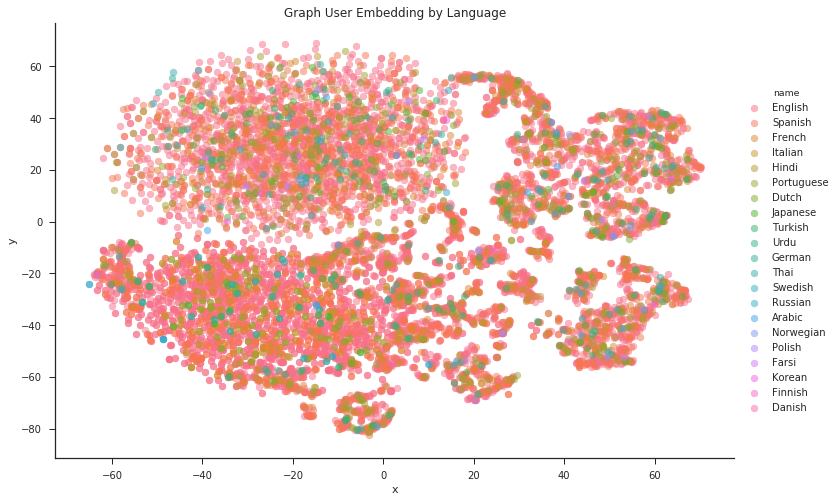

In [302]:
data_to_plot = data[data["name"] != "Not available"]
plot_grouped_embedding(data_to_plot, 'name', "Graph User Embedding by Language")

In the above graph, each point is a Twitter user and their location in the graph is determined by the 2-dimensional embedding output from the Node2Vec and t-SNE algorithms. Clusters, based on the Node2Vec algorithm that maximises the likelihood of user neighbours in the graph, can be observed. The users are coloured by language used in tweets. Languages appear uniformly across all the clusters, with no obvious groupings of users by language.

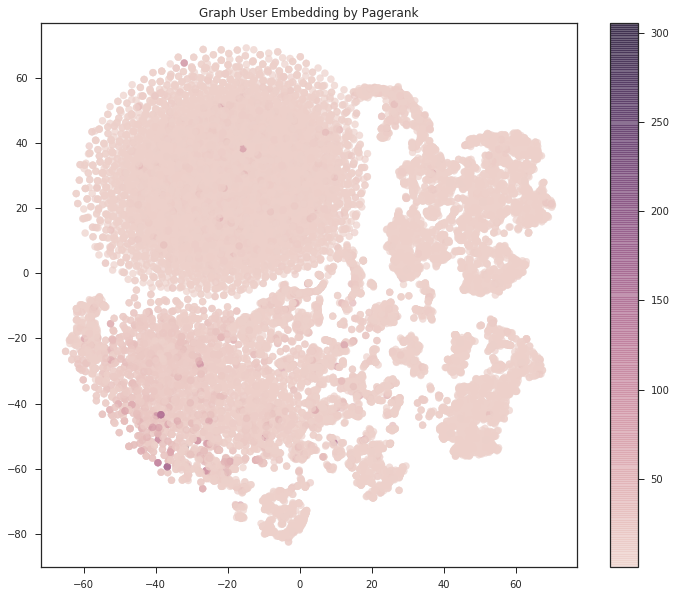

In [303]:
data_to_plot = data 
plot_gradient_embedding(data_to_plot, 'pr', "Graph User Embedding by Pagerank")

For the same graph, users are no coloured by Pagerank. One can see that the majority of the users have low pagerank, how there small patch of higher ranked nodes in the lower cluster. 

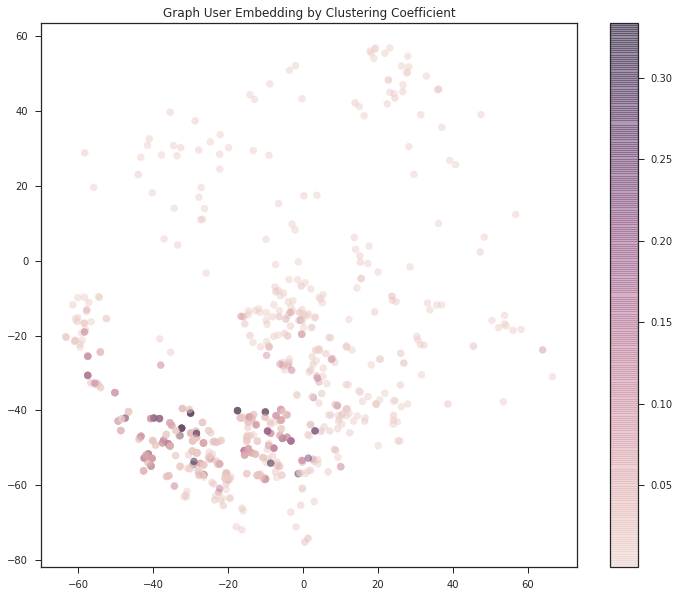

In [242]:
data_to_plot = data[data["coef"] != "not_available"]
plot_gradient_embedding(data_to_plot, 'coef', "Graph User Embedding by Clustering Coefficient")

Now the graph is coloured by clustering coefficients, (fewer users than before as those who have less than two neighbours have an nan values for the coefficient). It shows that Twitter users in the graph with higher clustering coefficients, appear closer together.